# Modeling Condenser Water Supply Temperature (CWSHDR) of INSEAD plant with standard regression techniques 

## A thought experiment.

CWSHDR is a timeseries and seasonal patterns can be observed looking at the data. However, the proposition is that Chiller Plants ideally follow the principles of theromodynamics and as such the the parameters logged by sensors demonstrate linear or non-linear relationship. And within a small time period during which seasonal patterns are irrelevant, standard regressions model might be able to capture the physical properties of this thermodynamic system.

## A quick look into the data

The below plots represent data from INSEAD Chiller Plant recorded on 17th May, 2017. Some zeros / null values may have been ignored to highlight the big-picture. These plots have been generated using Tableau.

### CWSHDR vs. Time (hours)

You would notice that as the day progresses, there is an increase in CWSHDR value and again reducing as the next day approaches. This trend can be noticed in the entire dataset and other chiller plants as well. Perhaps, this behavior can be attributed to "business hours" of the buildings.

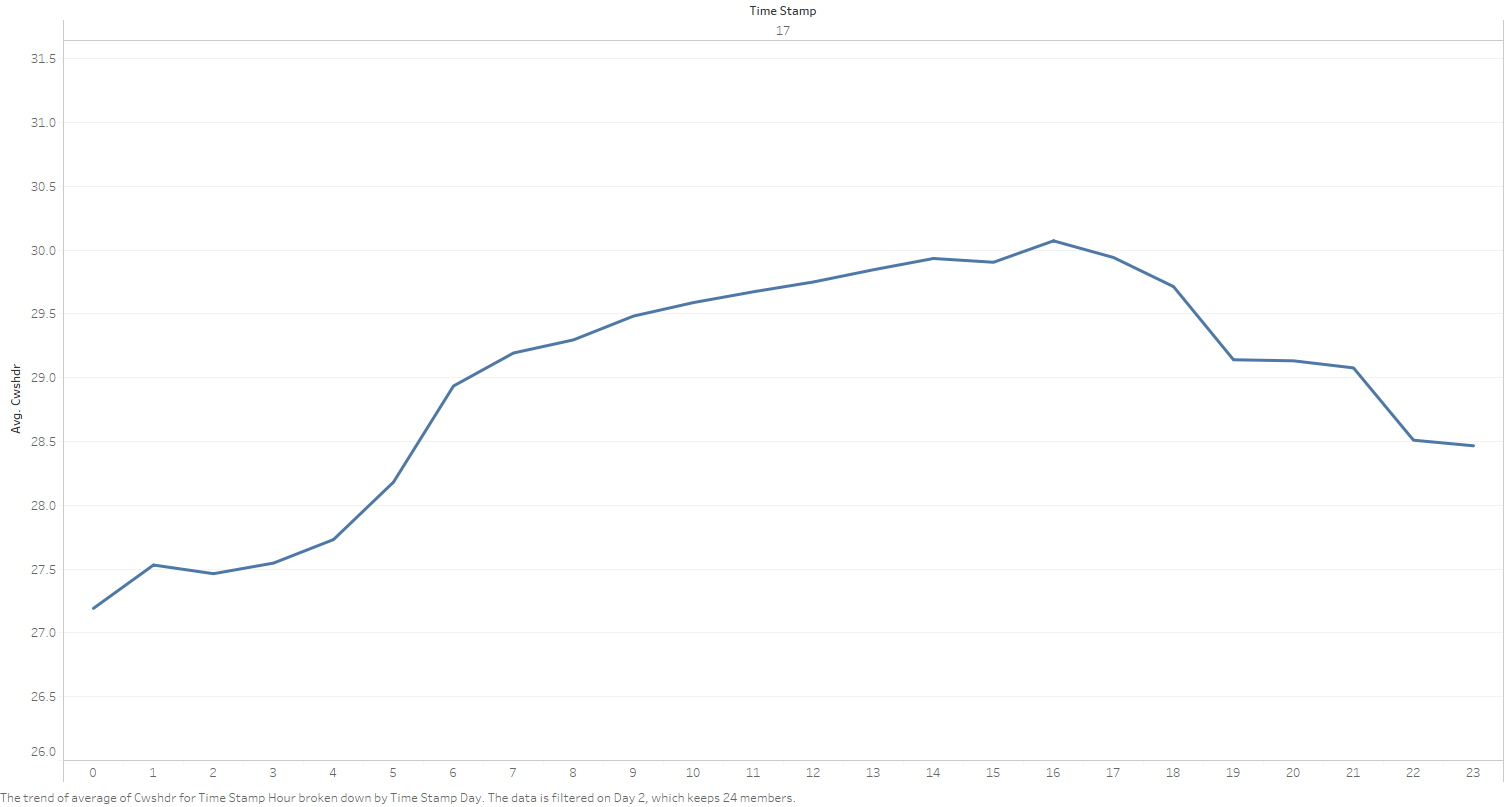

### CWSHDR vs. Drybulb.

1. Each color represents an hour (0-23) of 24 hours. Notice that data points of each hour can be grouped as a cluster! 
2. You could generally notice a up-ward increase of CWSHDR as Drybulb value increases

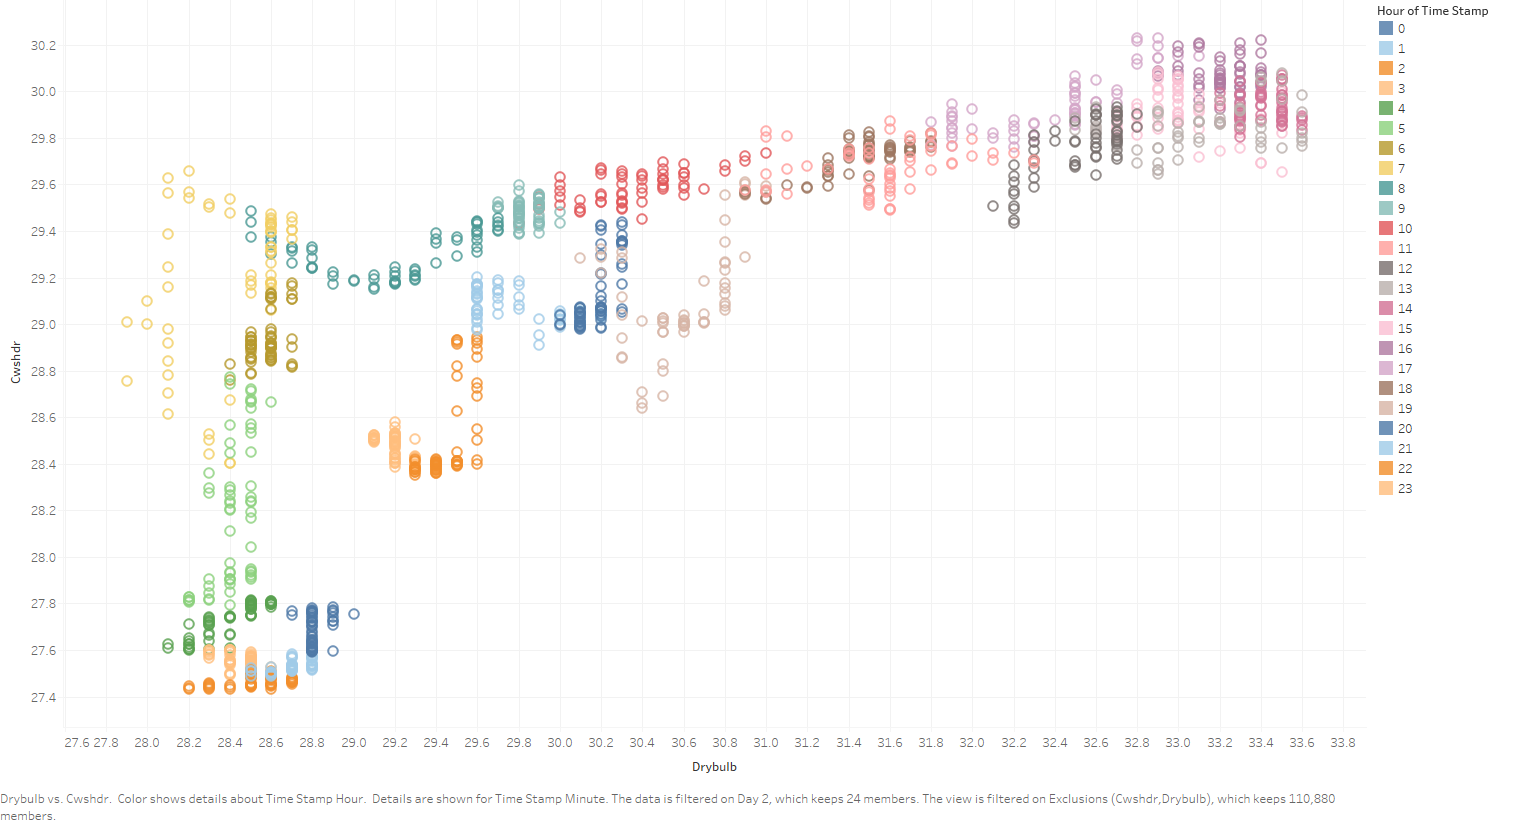

Let's look at the **entire data set (approx 8 months)**. Does the above listed charactersitcs satisfy? Well, yes indeed! 
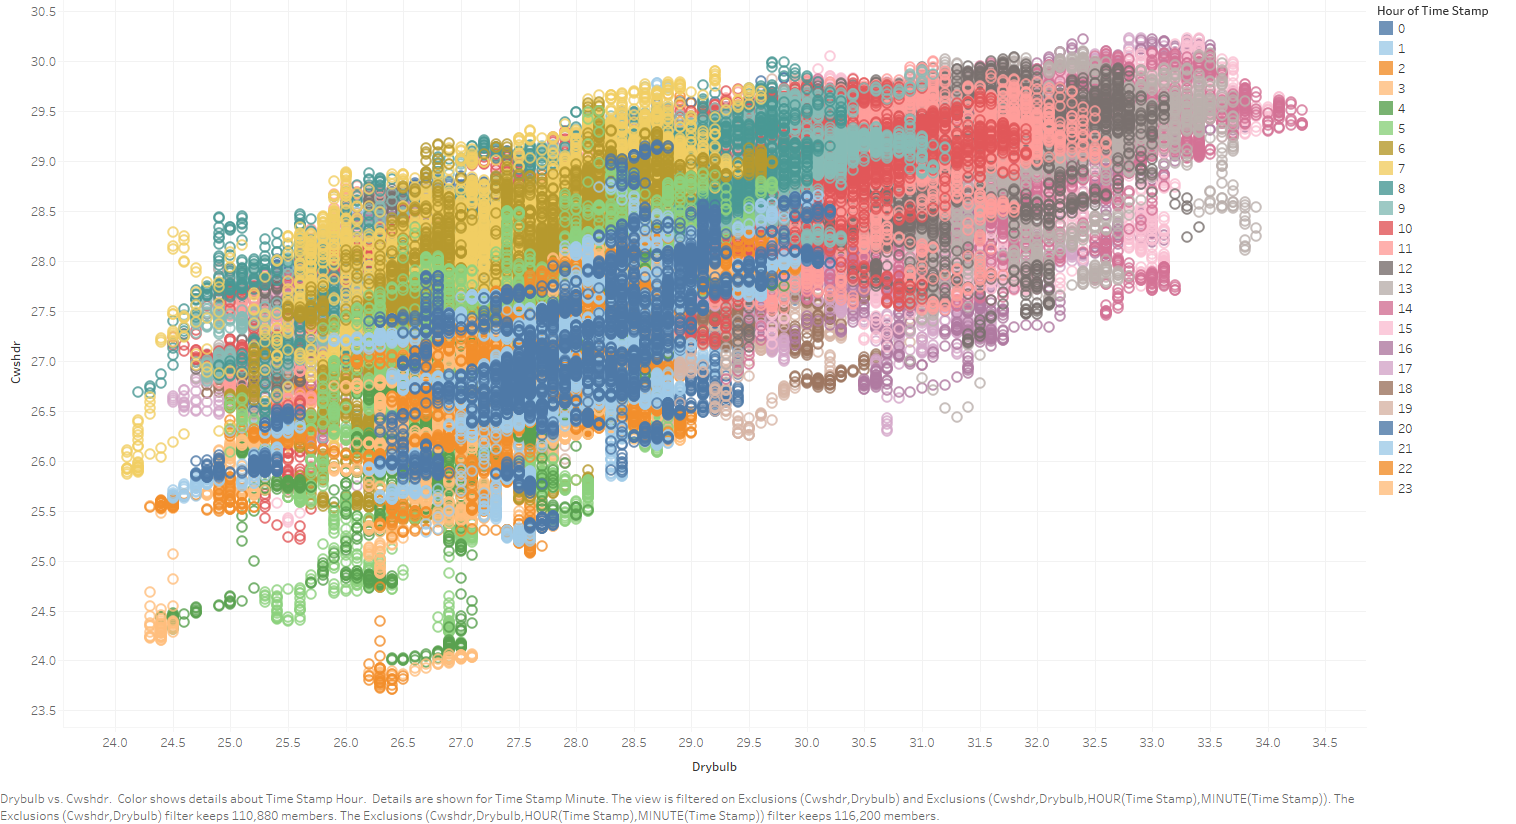

### CWSHDR vs. Rh

There is an downward trend with relative humidity while we observe an upward trend with Drybulb.

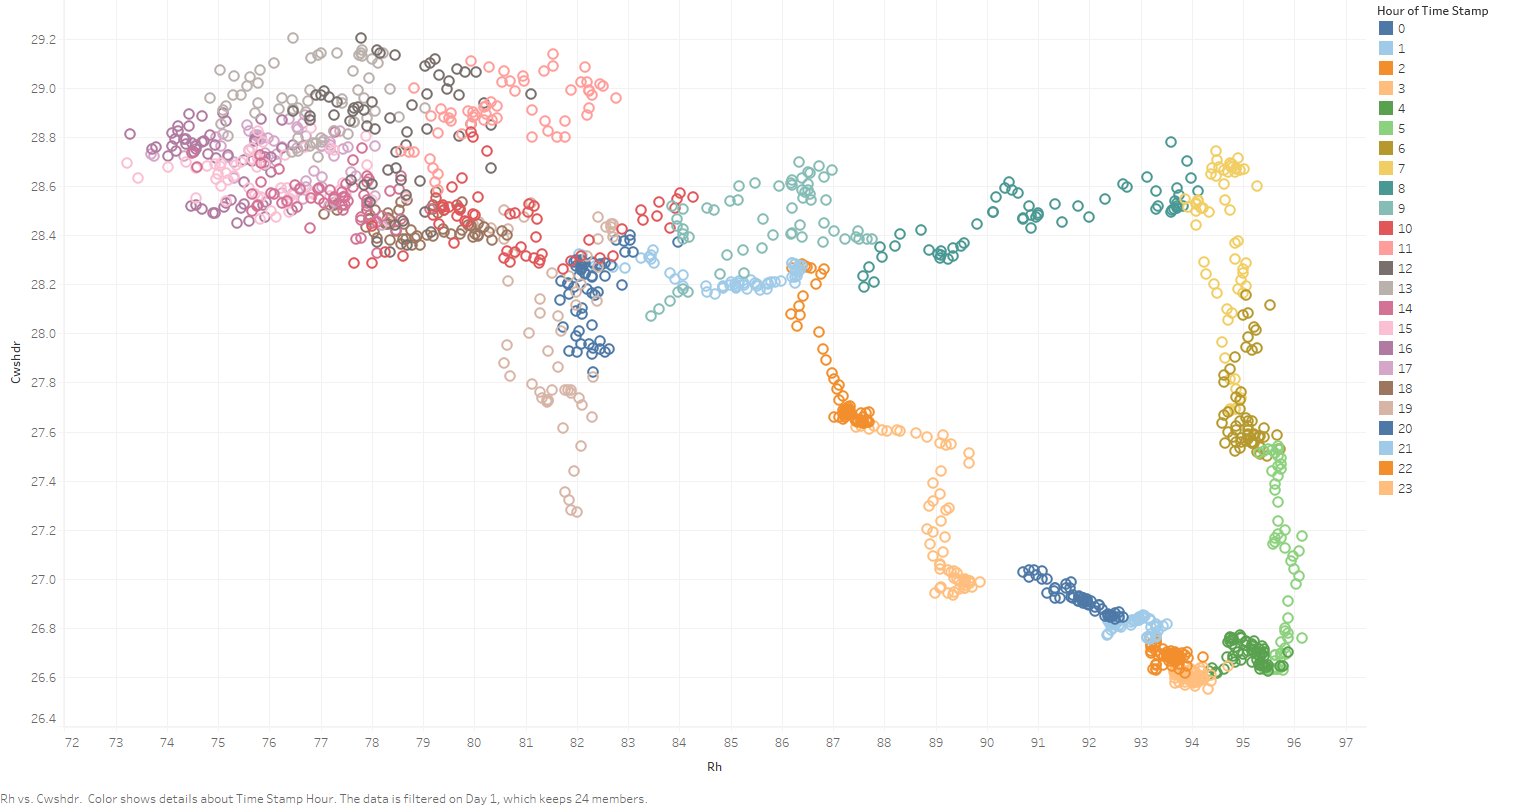

### CWSHDR vs. Loadsys

Coming back to the initial sample (one day data), we can notice an upward trend

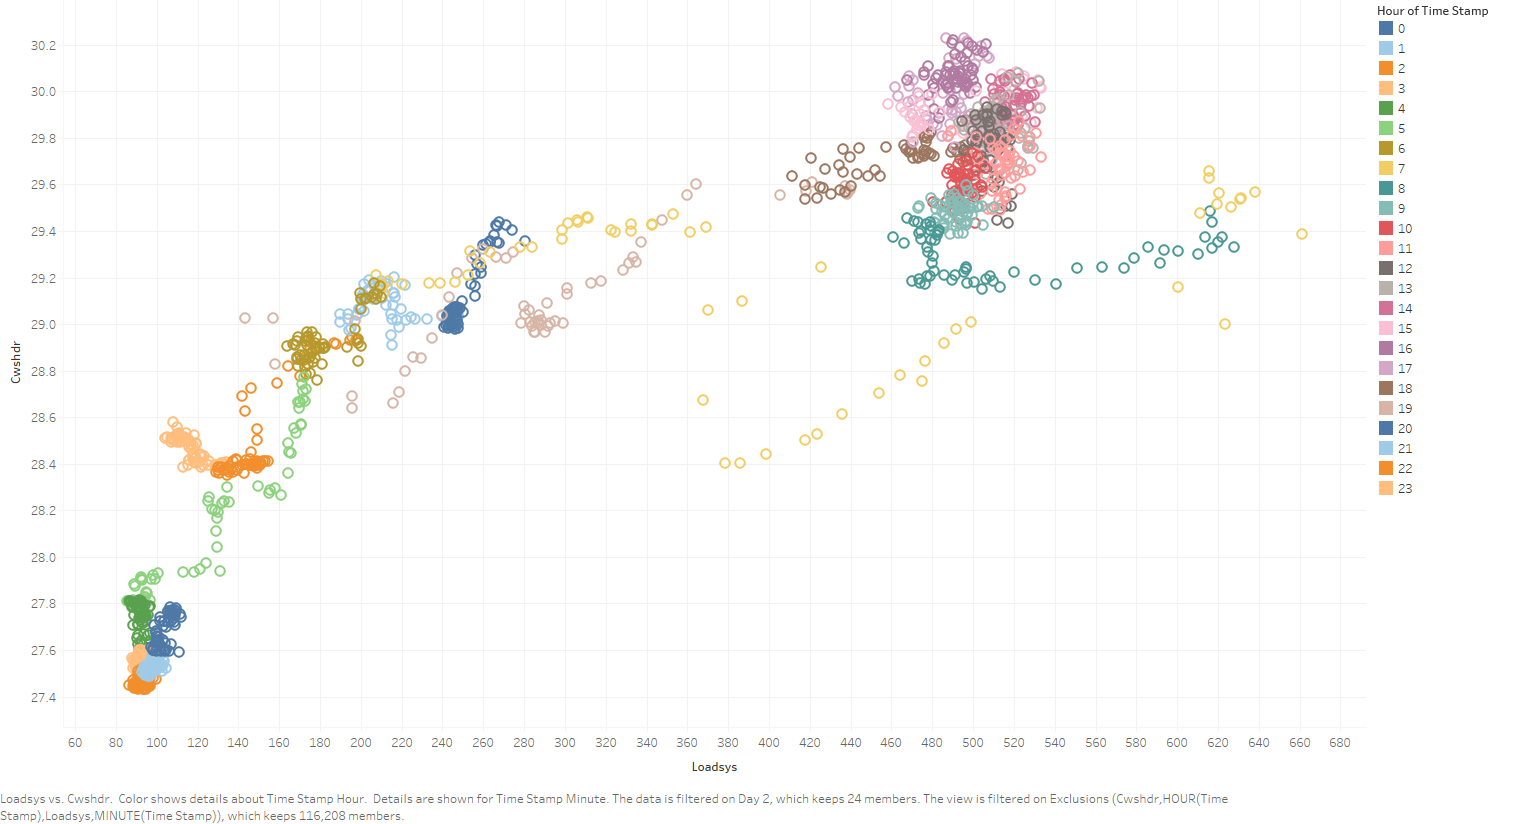

### CWSHDR vs. (CT1KW, CT2AKW)

I don't immediately read any observations that would help in modeling. However, its noticeable that one of the cooling tower is working while the other is shutdown (0KW power). This could be used in regression modeling. My assumptions is that each cooling tower may respond to its Inputs differently. Let's keep this in mind and take a look into how the regression's accuracy changes when the optimizer is given which cooling tower is working.. 

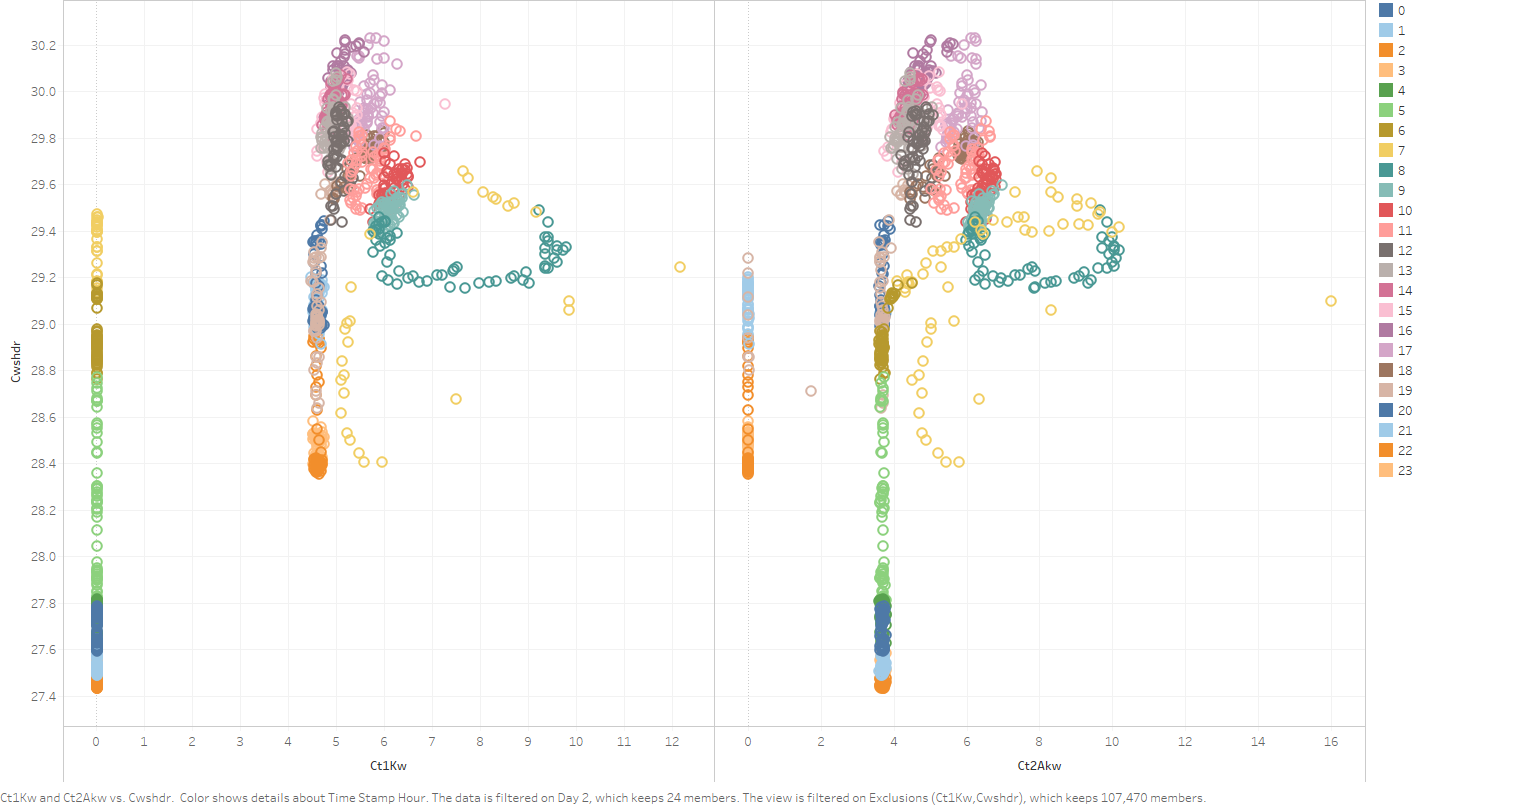

### CWSHDR vs. CWRHDR
The relationship seems obvious like in the above plots. A upward trend.
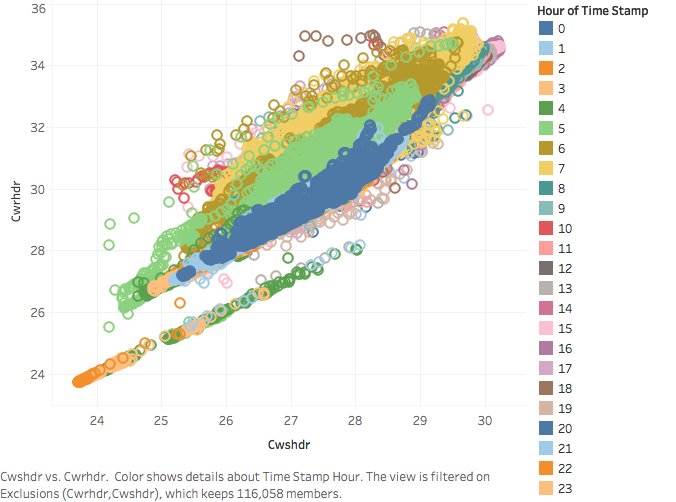

## Load data

Note: My hunch is that Decision Tree would be able to capture the Hour vs. {CWSHDR, Drybulb, Rh, CTKW} properties. So, an ensemble model could improve the accuracy.. Anyway, let's experiment these stuff. But before, let's load the data!!

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np
import glob
import os

In [76]:
# load all csv files of North-point site. Concatenate them..
data_src = "../data"
all_files = glob.glob(os.path.join(data_src, "insead", "*.csv"))
df = pd.concat([pd.read_csv(f, low_memory=False) for f in all_files], ignore_index=True)

# minor changes
df = df.rename(columns={"Time Stamp": "timestamp"})
df = df.replace("\\N", np.nan)

# update data types. object is taken as default
dtypes = dict([(col, np.float64) for col in df.columns])
dtypes["timestamp"] = "datetime64[ns]"
df = df.astype(dtypes)

# change the index to timestamp.
df.index = df.timestamp

## Preprocessing

In [77]:
# Percentage of null values..
(df.count() * 100)  / df.timestamp.count()

timestamp      100.000000
chwrhdr        100.000000
chwshdr        100.000000
chwsfhdr       100.000000
cwshdr         100.000000
cwrhdr         100.000000
cwsfhdr        100.000000
ch1kw          100.000000
ch2kw          100.000000
ch3kw          100.000000
chwp1kw        100.000000
chwp2kw        100.000000
chwp3kw        100.000000
chwp4kw         99.978185
cwp1kw         100.000000
cwp2kw         100.000000
cwp3kw          99.501368
ct1kw          100.000000
ct2akw          99.989958
incomingkw1     99.978185
incomingkw2     99.978185
rh              99.978877
drybulb         99.978877
chiller_eff    100.000000
cwp_eff        100.000000
chwp_eff       100.000000
ct_eff         100.000000
chwgpmrt       100.000000
cwgpmrt        100.000000
systotpower    100.000000
loadsys        100.000000
effsys         100.000000
hbsys          100.000000
dtype: float64

You'd notice above there are some null values in the columns we are interested. i.e, Drybulb, Rh, Ct2akw. But there are not too many. So, I'll drop respective data points from the dataset. Anyway, were not viewing this data as timeseries.

In [164]:
# select the interested features.. 
data = df[ ["cwshdr", "loadsys", "drybulb", "ct1kw", "ct2akw", "rh", "cwrhdr"] ].dropna()

In [165]:
data.describe()

,cwshdr,loadsys,drybulb,ct1kw,ct2akw,rh,cwrhdr
count,288701.000000,288701.000000,288701.000000,288701.000000,288701.000000,288701.000000,288701.000000
mean,27.394906,251.938826,27.964800,4.224875,3.550149,86.280931,30.657210
std,1.315870,152.731074,2.024122,3.062855,2.827426,7.229243,2.221389
min,0.000000,-499.065000,0.000000,0.000000,0.000000,-15.677400,0.000000
25%,26.589000,94.808300,26.400000,3.904000,0.010000,81.791700,29.161800
50%,27.539600,236.154000,27.800000,4.672000,3.728000,87.703300,31.119900
75%,28.307100,394.036000,29.300000,5.056000,4.512000,91.676900,32.352900
max,32.878900,998.501000,34.300000,24.832000,23.552000,99.217800,40.004600


In [166]:
# Also, let's see the median and mode.
print(data.median())
print(data.mode())

cwshdr      27.5396
loadsys    236.1540
drybulb     27.8000
ct1kw        4.6720
ct2akw       3.7280
rh          87.7033
cwrhdr      31.1199
dtype: float64
   cwshdr  loadsys  drybulb  ct1kw  ct2akw       rh  cwrhdr
0     0.0      0.0     28.1   4.64   3.712  88.9575     0.0


In [167]:
# Number of zeros. Zeros could mean nothing...? 
# Basic regression models can respond to these zeros pretty aggresively. So, what should we do?
#
# Case 1: If the sudden drop to approx. 0 stays for a very-short period, it shouldn't be 0?
# Case 2: If the sudden drop to approx. 0 stays for a very-long period, the system is shut down? 
# Case 3: Is it okay to have -ve values?
print((data<0).sum())
print(((data<=0.0001) & (data > 0)).sum())

# Let's make values below the threshold (defined above) 0. Assuming "system shut-down"
data.loadsys[data.loadsys < 0] = 0
data.rh[data.rh < 0 ] = 0

cwshdr        0
loadsys    1025
drybulb       0
ct1kw         0
ct2akw        0
rh            2
cwrhdr        0
dtype: int64
cwshdr     0
loadsys    0
drybulb    0
ct1kw      0
ct2akw     0
rh         0
cwrhdr     0
dtype: int64


In [168]:
# normalize the data
from sklearn import preprocessing

columns = data.columns
index = data.index.values

scaler = preprocessing.MinMaxScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns=columns, index=index)

## Training the regression models

In [198]:
# preparing some extra features.
data["hour"] = data.index.hour
data["minute"] = data.index.minute
data["hour_sqr"] = data.hour.apply(lambda x: x**2)
data["minute_sqr"] = data.minute.apply(lambda x: x**2)


# take the sample we're interested in.
train = data["2017-05-17":"2017-05-17"]  # Train on this day
test = data["2017-05-18":"2017-05-18"] # Test on the next day

# consider the target and features for training
features = ["loadsys", "drybulb", "rh", "cwrhdr", "hour_sqr", "minute_sqr"]
target = "cwshdr"

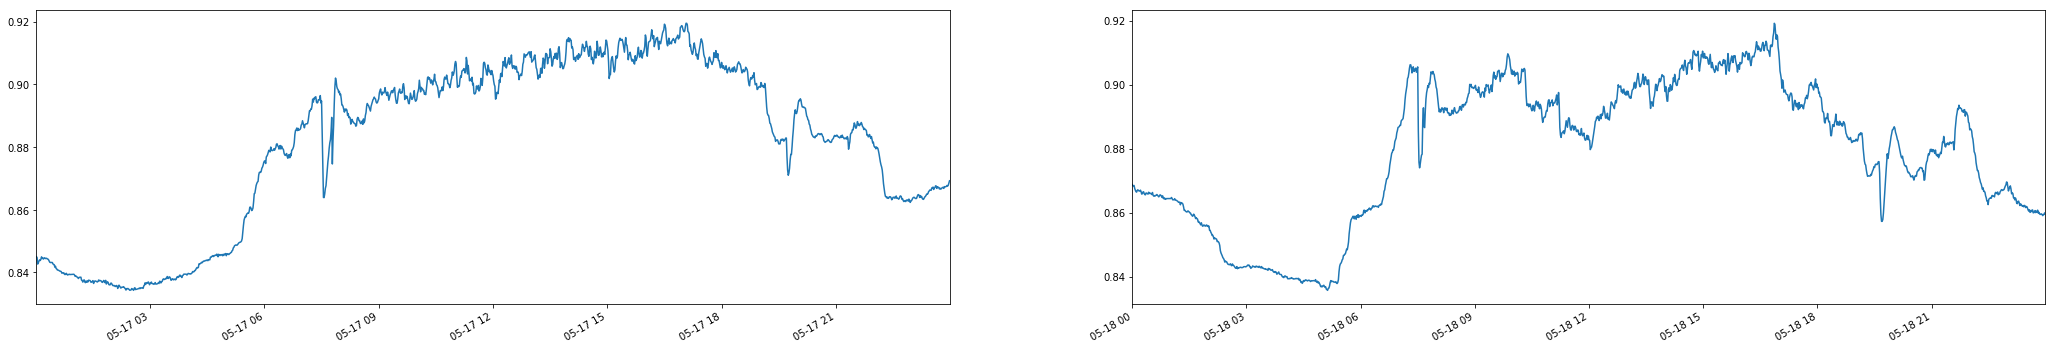

In [195]:
# let's see how the train, test and validation samples of cwshdr
fig, (a1, a2) = plt.subplots(1,2, figsize=(36,6))
train.cwshdr[1:].plot(ax=a1) ## ignore first value 0, for better representation. we could change axis instead.
test.cwshdr.plot(ax=a2)

In [225]:
from sklearn import linear_model
from sklearn import metrics 

# fit the model
reg = linear_model.LinearRegression()
reg.fit(train[features].values, train[target].values)

# check the metrics
y_predict = reg.predict(test[features].values)
y_test = test[target].values
print("MSE: ", metrics.mean_squared_error(y_test, y_predict))
print("Variance score: ", metrics.explained_variance_score(y_test, y_predict), "(1 is the best)")
print("R Squared score: ", reg.score(test[features].values, test[target].values))

MSE:  1.57823572174e-05
Variance score:  0.967333469049 (1 is the best)
R Squared score:  0.967282941304


## Observations
1. Removing CT1KW, CT2AKW has improved variance score by 0.30. Is this because the values haven't been preprocessed properly? Need to really come to good conclusion / proper plan on this.

2. My initial assumption that the data is proportional to $hours^2$ and $minute^2$ (poly regression) has not produced good results. The assumption is based on the empirical observation that CWSHDR looks approx. like a parabola. Hours and Minute data appared to be good indicators for the 2nd-degree polynomial in this case..

3. The *interesting* thing is, the variance score doesn't decrease much even after removing $hour$ and $minute$ features. **Looks like my inital hypothesis that time could become irrelevant can be investigated more deeply**

## Plot the prediction

(0.8, 0.93)

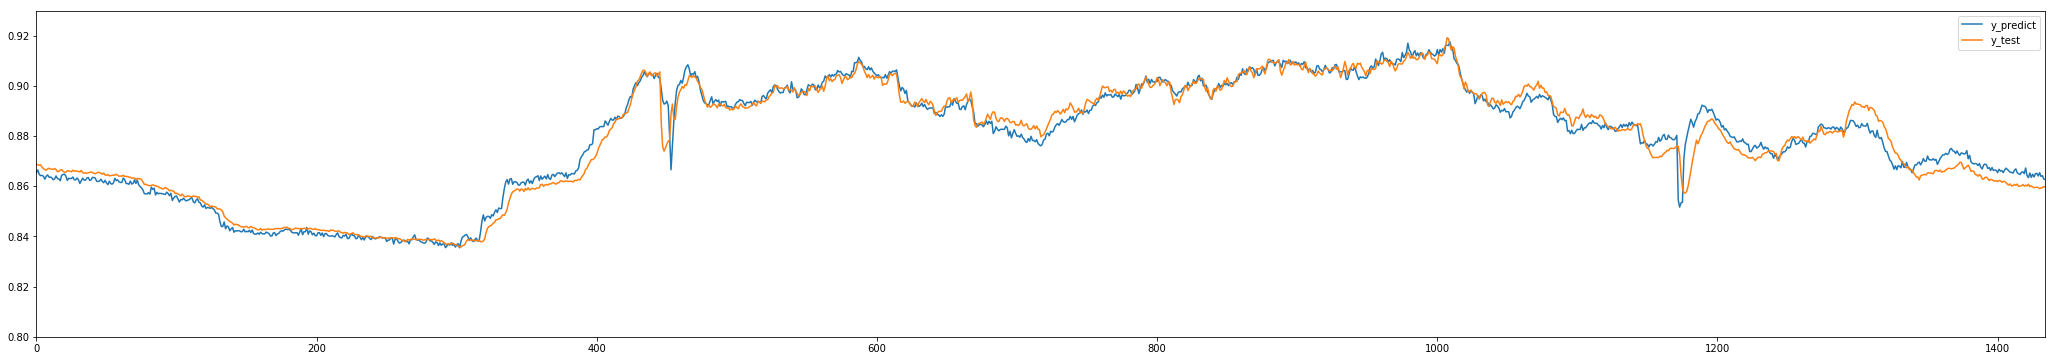

In [226]:
df_plot = pd.DataFrame({"y_test": y_test, "y_predict": y_predict})
fig, ax = plt.subplots(1, 1, figsize=(36,6))
df_plot.plot(ax=ax)
ax.set_ylim(0.8, 0.93)

**Interesting! Linear regression really captured the general big-picture charactersitcs of the model. Can we use this as an intermediate step for tuning?** However, where did this linear model made incorrect decisions? Let's look at those first.

## Let's test this model on several samples..

Starting with 17th May, 2017 for the next 30 days, the linear model is iteratively trained with a day's data and tested with corresponding next day's data. I.e, 
```
For each day in (30 days):
   - Train this day's data
   - Test with next day's data
```

In [272]:
import datetime as dt

# data := data, numpy nd array.
# start := dt.date object
# period := # of consecutive datys to test
def run(data, start, period):
    # metrics store
    mse_list = []
    score_list = []
    
    # starting date
    start_date = start
    
    for _ in range(period):
        # select the dates. Train with data of day N, test on N+1 day.
        date_train = start_date.strftime("%Y-%m-%d")
        date_test = (start_date + dt.timedelta(days=1)).strftime("%Y-%m-%d")
    
        # take the sample we're interested in.
        train = data[date_train:date_train]  # Train on this day
        test = data[date_test:date_test] # Test on the next day

        # consider the target and features for training
        features = ["loadsys", "drybulb", "rh", "cwrhdr", "hour_sqr", "minute_sqr"]
        target = "cwshdr"
        
        # fit the model
        reg = linear_model.LinearRegression()
        reg.fit(train[features].values, train[target].values)

        # Log the metrics
        y_predict = reg.predict(test[features].values)
        y_test = test[target].values
        mse_list.append(metrics.mean_squared_error(y_test, y_predict))
        score_list.append(metrics.explained_variance_score(y_test, y_predict))
        
        print("Train: ", start_date, "Test: ", start_date + dt.timedelta(1), "Score: ", score_list[-1])
    
        # update the start date
        # NOTE: This worked well without updating the start date. That means
        # there has to be something with selecting "good" dataset for training..
        start_date = start_date + dt.timedelta(1)
        
    return mse_list, score_list

Train:  2017-05-17 Test:  2017-05-18 Score:  0.967333469049
Train:  2017-05-18 Test:  2017-05-19 Score:  0.948935962111
Train:  2017-05-19 Test:  2017-05-20 Score:  0.937258882159
Train:  2017-05-20 Test:  2017-05-21 Score:  0.962581799497
Train:  2017-05-21 Test:  2017-05-22 Score:  0.974900107746
Train:  2017-05-22 Test:  2017-05-23 Score:  0.986674495431
Train:  2017-05-23 Test:  2017-05-24 Score:  0.865149207118
Train:  2017-05-24 Test:  2017-05-25 Score:  0.979377602194
Train:  2017-05-25 Test:  2017-05-26 Score:  0.850114659212
Train:  2017-05-26 Test:  2017-05-27 Score:  0.969447732231
Train:  2017-05-27 Test:  2017-05-28 Score:  0.934209338175
Train:  2017-05-28 Test:  2017-05-29 Score:  0.643690247567
Train:  2017-05-29 Test:  2017-05-30 Score:  0.78956382281
Train:  2017-05-30 Test:  2017-05-31 Score:  0.941817263258
Train:  2017-05-31 Test:  2017-06-01 Score:  0.978859998027
Train:  2017-06-01 Test:  2017-06-02 Score:  0.955923544214
Train:  2017-06-02 Test:  2017-06-03 Scor

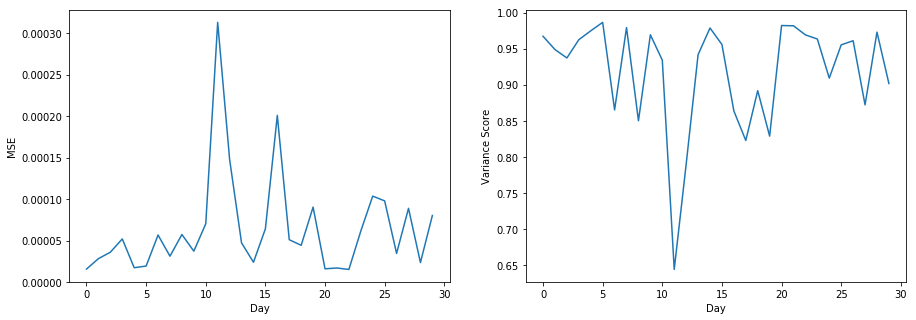

In [273]:
mse_list, score_list = run(data=data, start=dt.date(2017,5,17), period=30)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(mse_list); ax[0].set_xlabel("Day"); ax[0].set_ylabel("MSE");
ax[1].plot(score_list); ax[1].set_xlabel("Day"); ax[1].set_ylabel("Variance Score")

**Why are there sudden increase in errors?**

MSE:  0.00017457385874
Variance score:  0.820389892015 (1 is the best)
R Squared score:  0.719625320327


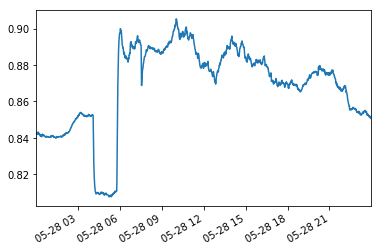

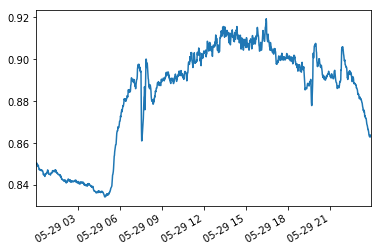

In [280]:
train = data["2017-05-28":"2017-05-28"]
test = data["2017-05-29":"2017-05-29"]

reg = linear_model.LinearRegression()
reg.fit(train[features].values[1:], train[target].values[1:])

y_predict = reg.predict(test[features].values)
y_test = test[target].values

print("MSE: ", metrics.mean_squared_error(y_test, y_predict))
print("Variance score: ", metrics.explained_variance_score(y_test, y_predict), "(1 is the best)")
print("R Squared score: ", reg.score(test[features].values, test[target].values))

plt.figure()
ax = train.cwshdr[1:].plot()

plt.figure()
ax = test.cwshdr[1:].plot()

**Oh!! There are probably zeros in the train data. That's the reason why matplotlib didn't scale the y-axis automatically similar to the 2nd plot.** Looks like zeros are effecting the prediction!!